In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("D:\data prep\dseb63_final_project_DP_dataset\dseb63_final_project_DP_dataset\dseb63_bureau_balance.csv")
df.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


# TABLE DESCRIPTION

In [3]:
description = pd.read_csv('D:\data prep\project data\dseb63_columns_description.csv',encoding='latin',index_col=0)
description = description[description['Table'].str.contains('bureau_balance')].drop(columns = 'Table',axis = 0).set_index("Row")
description

,Description,Special
Row,,
SK_BUREAU_ID,Recoded ID of Credit Bureau credit (unique cod...,hashed
MONTHS_BALANCE,Month of balance relative to application date ...,time only relative to the application
STATUS,Status of Credit Bureau loan during the month ...,NaN


# CHECK DUPES

In [4]:
df.duplicated().sum()

0

# CHECK NULL

In [5]:
number_missing = df.isnull().sum()
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'number_missing' : number_missing,
                                 'percent_missing': percent_missing})
missing_value_df

,column_name,number_missing,percent_missing
SK_ID_BUREAU,SK_ID_BUREAU,0,0.0
MONTHS_BALANCE,MONTHS_BALANCE,0,0.0
STATUS,STATUS,0,0.0


In [6]:
columns = df.loc[:,(df.isnull().sum(axis = 0) / df.shape[0]) >= 0.9].columns
columns

Index([], dtype='object')

I didn't find any column with null values. So removing is not necessary

# CHECK OUTLIERS

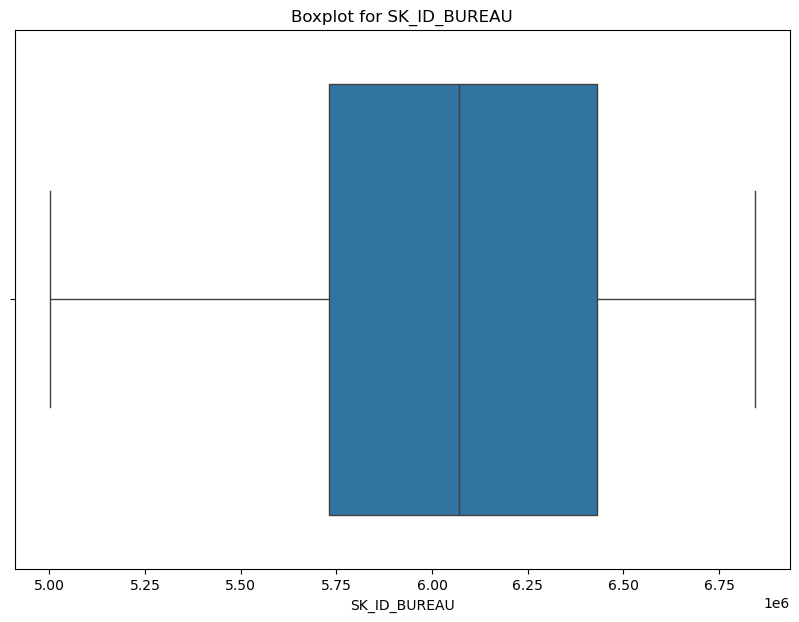

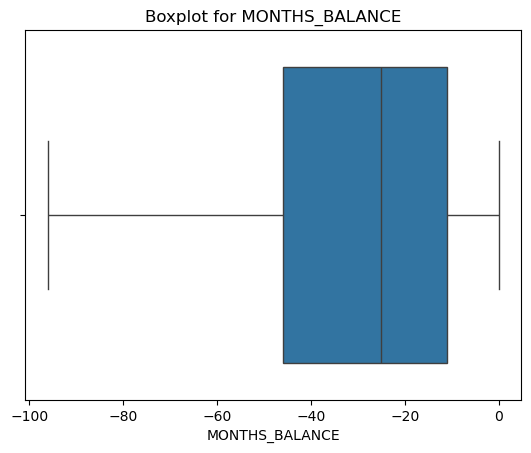

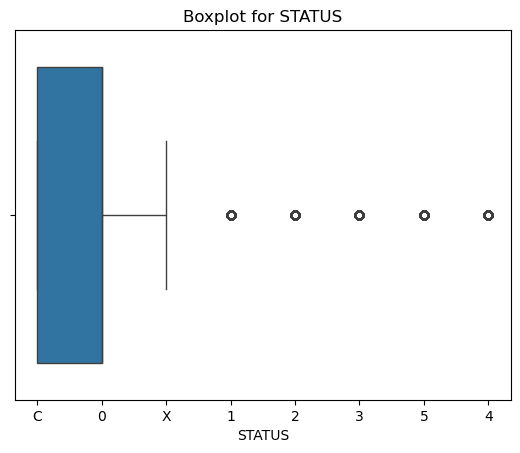

In [7]:
plt.figure(figsize=(10, 7))

for column in df.columns:
    sns.boxplot(x=df[column])

    plt.title(f'Boxplot for {column}')

    plt.show()

# CHECK VALID

In [8]:
numerical_data = df._get_numeric_data()

In [9]:
for column in numerical_data.columns:
    value_counts = numerical_data[column].apply(lambda x: '>0' if x > 0 else ('=0' if x == 0 else '<0')).value_counts()
    
    for cat in ['>0', '=0', '<0']:
        if cat not in value_counts:
            value_counts[cat] = 0
    
    nan_total = numerical_data[column].isnull().sum()
    other_value = numerical_data.shape[0] - value_counts.sum() - nan_total

    print(f'{column} has  >0: {value_counts[">0"]}, =0: {value_counts["=0"]}, <0: {value_counts["<0"]}, nan: {nan_total}, other values: {other_value}')

SK_ID_BUREAU has  >0: 27299925, =0: 0, <0: 0, nan: 0, other values: 0
MONTHS_BALANCE has  >0: 0, =0: 610965, <0: 26688960, nan: 0, other values: 0


In [10]:
categorical_data = df.drop(columns=numerical_data.columns)

In [11]:
for column in categorical_data.columns:
    unique_values = categorical_data[column].unique()
    print(f'col {column} : {list(unique_values)}\n')

col STATUS : ['C', '0', 'X', '1', '2', '3', '5', '4']



# EDA Internal

## Univariate Analysis

# CHECK DISTRIBUTION OF CATEGORICAL

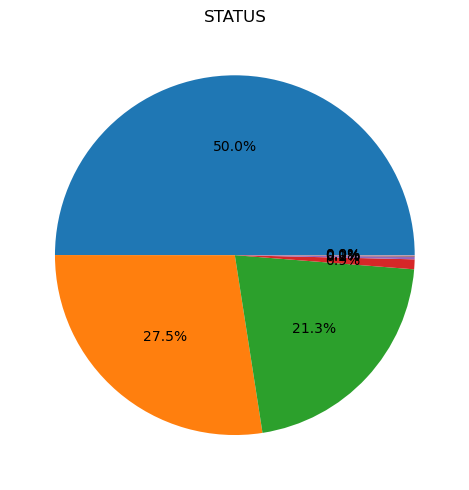

In [12]:
column_name = categorical_data.columns[0]

sizes = categorical_data[column_name].value_counts(normalize=True)

fig, ax = plt.subplots(figsize=(5, 5))

ax.pie(sizes, autopct='%1.1f%%')
ax.set_title(column_name, color='black')

plt.tight_layout()
plt.show()

In [13]:
print(f"\nInsights for {column_name}:")
    
for category, percentage in sizes.iteritems():
    print(f"{category}: {percentage * 100:.2f}%")
    
print(f"Total Unique Categories: {len(sizes)}")


Insights for STATUS:
C: 49.99%
0: 27.47%
X: 21.28%
1: 0.89%
5: 0.23%
2: 0.09%
3: 0.03%
4: 0.02%
Total Unique Categories: 8


C:\Users\Admin\AppData\Local\Temp\ipykernel_6444\3896291981.py:3: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for category, percentage in sizes.iteritems():


49.99% là các khoản nợ đã đóng\

27.47% không được thanh toán đúng hạn và phải chịu phí trễ\

21.28% là các khoản nợ chưa xác định tình trạng

## Bivariate Analysis

# CREATE CORRELATION MATRIX

In [14]:
correlation_matrix = df.corr()
correlation_matrix

C:\Users\Admin\AppData\Local\Temp\ipykernel_6444\868109210.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


,SK_ID_BUREAU,MONTHS_BALANCE
SK_ID_BUREAU,1.000000,0.011873
MONTHS_BALANCE,0.011873,1.000000


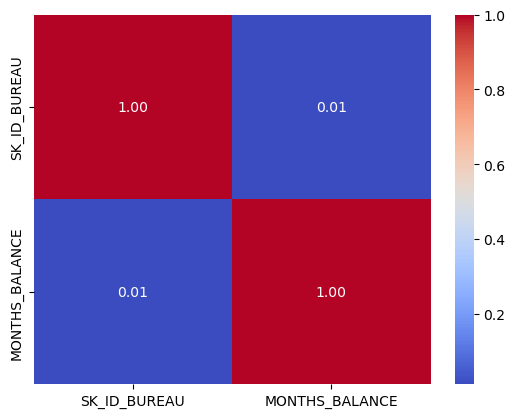

In [15]:
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

In [16]:
max_corr = correlation_matrix.unstack().sort_values(ascending=False).drop_duplicates()
min_corr = correlation_matrix.unstack().sort_values().drop_duplicates()
print("Các cặp features có correlation cao nhất:\n", max_corr.head())

Các cặp features có correlation cao nhất:
 SK_ID_BUREAU  SK_ID_BUREAU      1.000000
              MONTHS_BALANCE    0.011873
dtype: float64


# MERGE WITH TARGET TABLE

## EDA External

In [17]:
df2 = pd.read_csv("D:\data prep\dseb63_final_project_DP_dataset\dseb63_final_project_DP_dataset\dseb63_bureau.csv")
df2.head()

,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,SK_ID_CURR
0,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN,254629
1,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN,254629
2,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN,254629
3,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN,254629
4,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN,254629


In [18]:
df3 = pd.read_csv("D:\data prep\dseb63_final_project_DP_dataset\dseb63_final_project_DP_dataset\dseb63_application_train.csv")
df3.head()

,Unnamed: 0,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,SK_ID_CURR
0,0,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,278621
1,1,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,139008
2,2,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,138348
3,3,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,...,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0,64140
4,4,0,Cash loans,M,Y,Y,0,360000.0,1530000.0,42075.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,219374


In [19]:
merge_table_prev = pd.merge(df2[['SK_ID_CURR','SK_ID_BUREAU']], df, how= 'left', on=['SK_ID_BUREAU'])
merge_table_prev.head()

,SK_ID_CURR,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,254629,5714462,NaN,NaN
1,254629,5714463,NaN,NaN
2,254629,5714464,NaN,NaN
3,254629,5714465,NaN,NaN
4,254629,5714466,NaN,NaN


In [20]:
merge_table = pd.merge(df3[["SK_ID_CURR", "TARGET"]], merge_table_prev, how='left', on=['SK_ID_CURR'])
merge_table.head()

,SK_ID_CURR,TARGET,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,278621,0,5885877.0,NaN,NaN
1,278621,0,5885878.0,NaN,NaN
2,278621,0,5885879.0,NaN,NaN
3,278621,0,5885880.0,NaN,NaN
4,139008,0,NaN,NaN,NaN


# CHECK DISTRIBUTION OF NUMERICAL

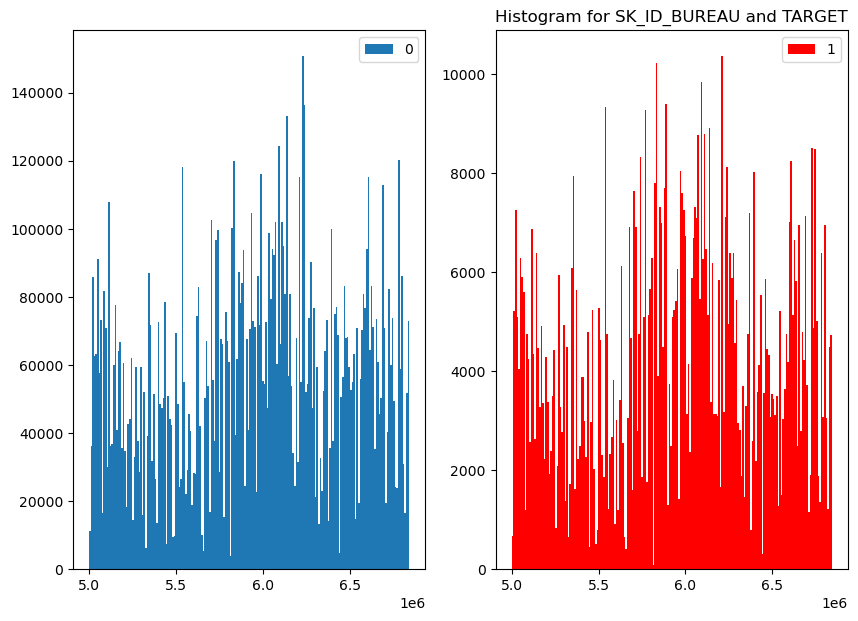

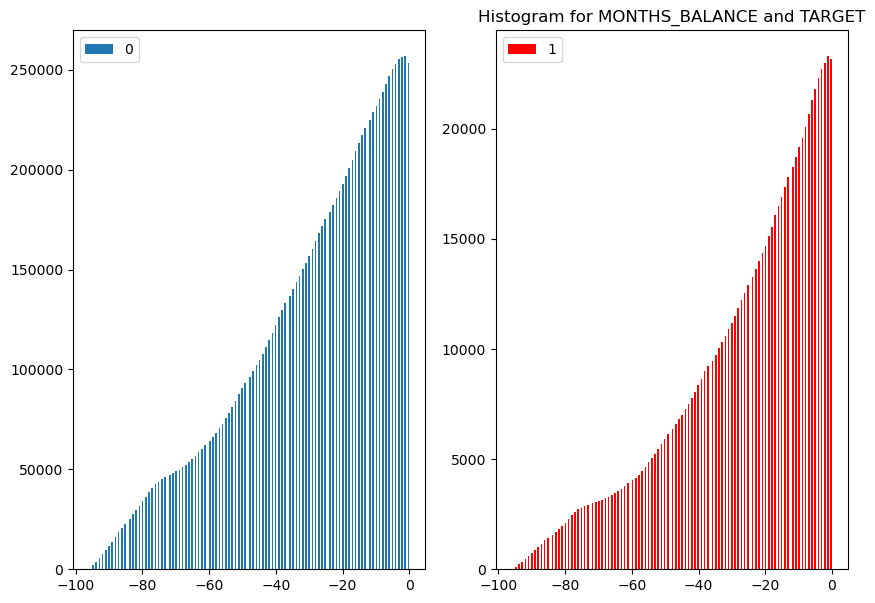

In [21]:
for col in numerical_data:
    fig,ax = plt.subplots(1,2,figsize =(10,7))
    class0 = merge_table[merge_table['TARGET']==0][col]
    class1 = merge_table[merge_table['TARGET']==1][col]
    ax[0].hist(class0,bins = 200,label = 0)
    ax[1].hist(class1,bins = 200,color = 'red',label= 1)
    ax[0].legend()
    ax[1].legend()
    plt.title(f'Histogram for {col} and TARGET')

### Distribution khá giống nhau --> Không ảnh hưởng nhiều đến biến TARGET